# Ilustration of the mqs package in R

We provide instructions on how to use the mqs package. For more information see [our mqs paper.](https://arxiv.org/abs/1902.09321)

## Installing the package

First we need to install the `devtools` package

In [18]:
install.packages("devtools")

Installing package into ‘/home/lvanegas/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)


Then we can install the `mqs` package directly from GitHub

In [20]:
library(devtools)

install_github("ljvanegas/mqs")

Your system is ready to build packages!



✔  checking for file ‘/tmp/Rtmp3F5cuS/remotes58b76438ad3e/ljvanegas-mqs-577f2e8/DESCRIPTION’
─  preparing ‘mqs’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘mqs_1.0.tar.gz’
   


Installing package into ‘/home/lvanegas/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)


## Example of median segmentation with simulated data

Load the package

In [21]:
library(mqs)

We can fix a seed to make thinks reproducible.

In [22]:
set.seed(1)

In this example we choose the following underlying signal mu

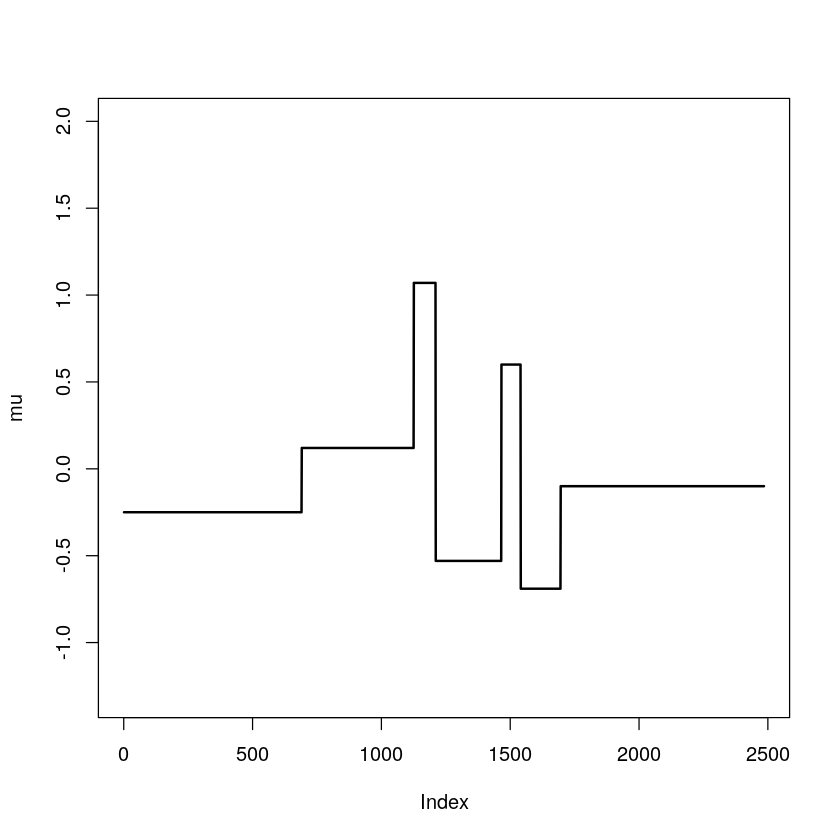

In [23]:
mu = c(rep(-0.25, 690), rep(0.12, 435), rep(1.07, 85), rep(-0.53, 255), rep(0.60, 75), rep(-0.69, 155), 
       rep(-0.10, 790))

plot(mu, type = "l", ylim = c(-1.3, 2), lwd = 2)

To the singal mu, we add non-homogeneous noise to obtain observations y. 
- The first 350 observations have standard normal noise 
- the following 1190 observations have t (3 d.f.) noise with variance 0.1
- the last 945 observations have chi-squared (1 d.f.) noise with variance 0.05.

Note that this data has median mu.

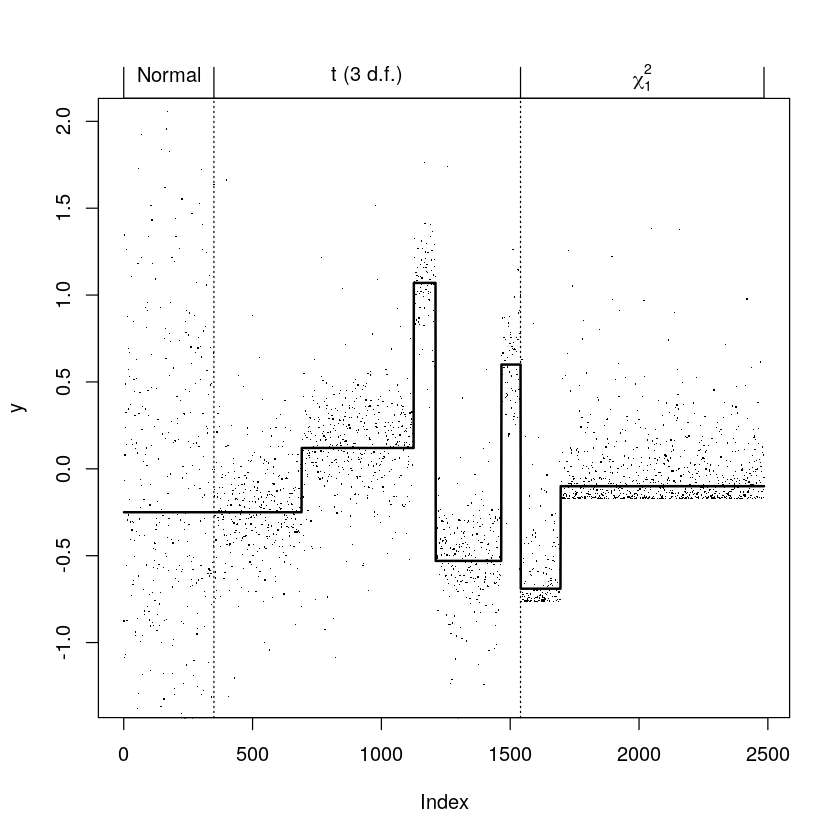

In [24]:
y = mu + c(rnorm(350, sd = sqrt(1)), rt(1540-350, df = 3)/sqrt(3)*sqrt(0.1), 
              (rchisq(length(mu)-1540, 1)-qchisq(0.5, 1))/sqrt(2)*sqrt(0.05))

plot(y, pch = ".", ylim = c(-1.3, 2))
lines(mu, lwd = 2)

# Mark the different distributions on top
axis(3, at = c(0, 175, 945, 2012.5, length(mu)), cex.axis=1, tck=0, 
     labels = c("" , "Normal", "t (3 d.f.)", expression(chi[1]^2), ""), padj=0.8)
axis(3, at = c(0, 350, 1540, length(mu)), tck=-0.05, labels = c("", "", "", ""))
abline(v = 350, lty=3)
abline(v = 1540, lty=3)

To calculate the mqse, one has to specify one of two parameters:
- **The level $\alpha$**: For a confidence level $\alpha\in(0,1)$, the `mqse` has the teorethical property that, with probability $1-\alpha$, the true number of segments is greater or equal than the estimated one. Therefore, $\alpha$ controls the overestimation error. A small $\alpha$ will lead to a conservative estimator, with less change points.
- **The threshold parameter $q$**: One can also choose a tunning parameter $q$, where it holds that the smaller $q$ is, more change points will be added to the signal. There is a direct theoretical relationship between $\alpha$ and $q$. For a more broad discussion see [our mqs paper.](https://arxiv.org/abs/1902.09321).

To obtain the mqse with $\alpha = 0.01$, run the following comand

In [25]:
sol <- mqse(y, alpha = 0.01)

The output of the mqse function will be a List of 4. 
- `value` is a vector that contains the estimated segment values 
- `left` is a vector that contains the estimated change point locations
- `n` is the number of observations
- `confInt` is a matrix with confidence intervals for the change point locations

In [26]:
str(sol)

List of 4
 $ value  : num [1:7] -0.269 0.145 1.084 -0.496 0.582 ...
 $ left   : int [1:7] 1 696 1133 1214 1475 1549 1701
 $ n      : int 2485
 $ confInt: int [1:6, 1:2] 117 996 1202 1456 1527 1602 698 1133 1221 1475 ...
 - attr(*, "class")= chr "mqs"


Note that the estimated number of segments is the length of the `value` and `left` vectors.

We can then plot our estimator (red line). Note that we use the function `fitted()` to extract the estimator.

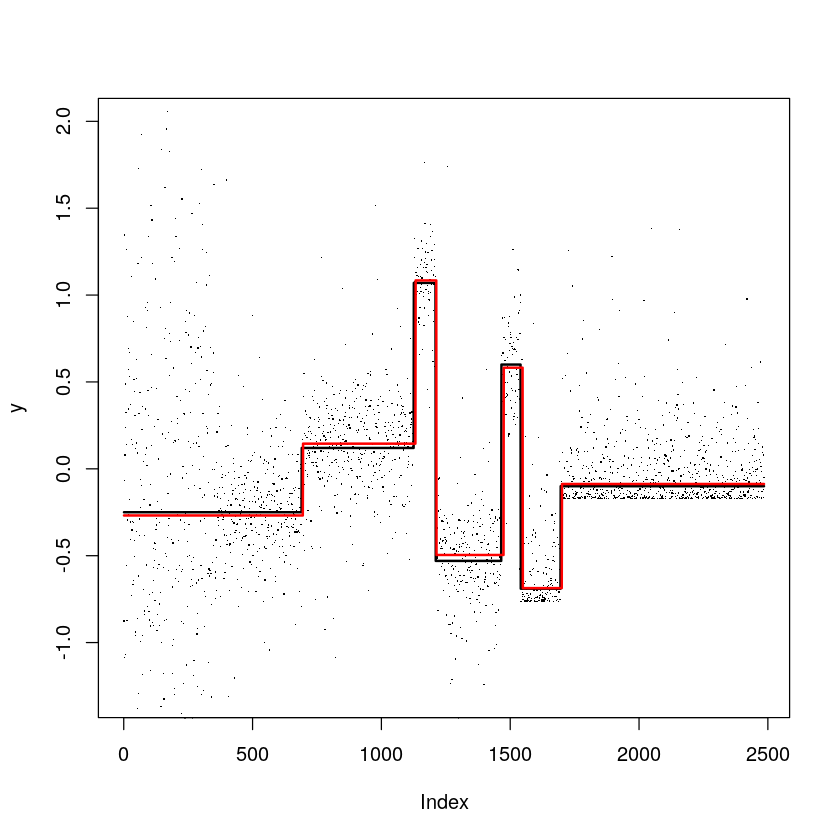

In [27]:
plot(y, pch = ".", ylim = c(-1.3, 2))
lines(mu, lwd = 2)
lines(fitted(sol), lwd = 2, col = "red")

### Confidence bands and intervals for median segmentation 

Additionaly, mqs provides confidence intervals for the change point locations and confidence bands for the median. To obtain them, set `conf = TRUE`.

In [28]:
sol <- mqse(y, alpha = 0.1, conf = TRUE)

The output of the function `mqse` will have to additional objects:
- `lowerCB` is the lower bound of the confidence band
- `upperCB` is the lower bound of the confidence band.

In [29]:
str(sol)

List of 6
 $ value  : num [1:7] -0.269 0.141 1.084 -0.491 0.582 ...
 $ left   : int [1:7] 1 694 1123 1211 1475 1549 1701
 $ n      : int 2485
 $ confInt: int [1:6, 1:2] 682 1115 1202 1456 1530 1690 697 1133 1221 1473 ...
 $ lowerCB: num [1:2485] -0.273 -0.273 -0.273 -0.273 -0.273 ...
 $ upperCB: num [1:2485] -0.269 -0.269 -0.269 -0.269 -0.269 ...
 - attr(*, "class")= chr "mqs"


One can then plot the confidence band (grey area), confidence intervals (blue intervals), and estimator (red line).

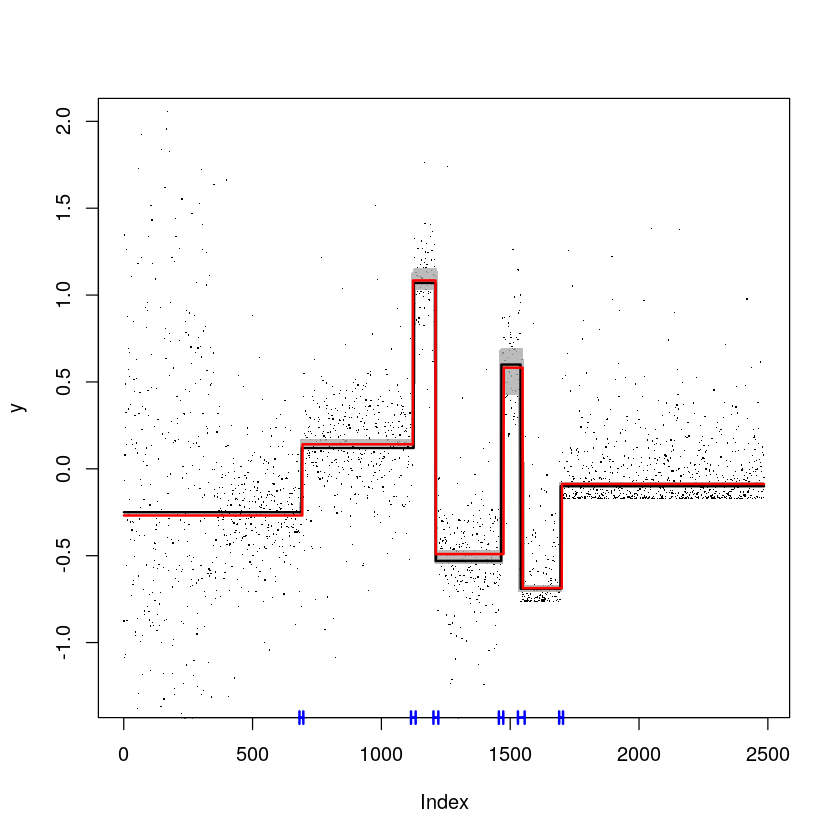

In [30]:
plot(y, pch = ".", ylim = c(-1.3, 2))

# Plot the confidence band 
polygon(c(1:length(mu), rev(1:length(mu))), c(sol$lowerCB, rev(sol$upperCB)), 
        col = rgb(169,169,169, 200, maxColorValue = 255), border =NA)

# Plot the true mu and the mqse
lines(mu, lwd=2)
lines(fitted(sol), lwd = 2, col = "red")

# Plot the confidence intervals
for(i in 1:nrow(sol$confInt)){
  axis(1, at = c(sol$confInt[i,1], sol$confInt[i,2]), labels = c("", ""), lwd = 2, tck=0.01, col="blue")
  axis(1, at = c(sol$confInt[i,1], sol$confInt[i,2]), labels = c("", ""), lwd = 2, tck=-0.01, col="blue")
}

Note that the confidence bands and intervals are very sharp around long segments and wider around small jumps.

### Estimation of other quantiles 

For an arbitrary quantile level $\beta\in(0,1)$, one can also estimate the mqse and calculate the confidence regions, by setting `beta`= $\beta$. For example if $\beta = 0.75$

In [31]:
sol <- mqse(y, beta = 0.75, alpha = 0.1, conf = TRUE)

One can then plot the estimator (light salmon), confidence bands (grey area), and confidence intervales (blue lines).

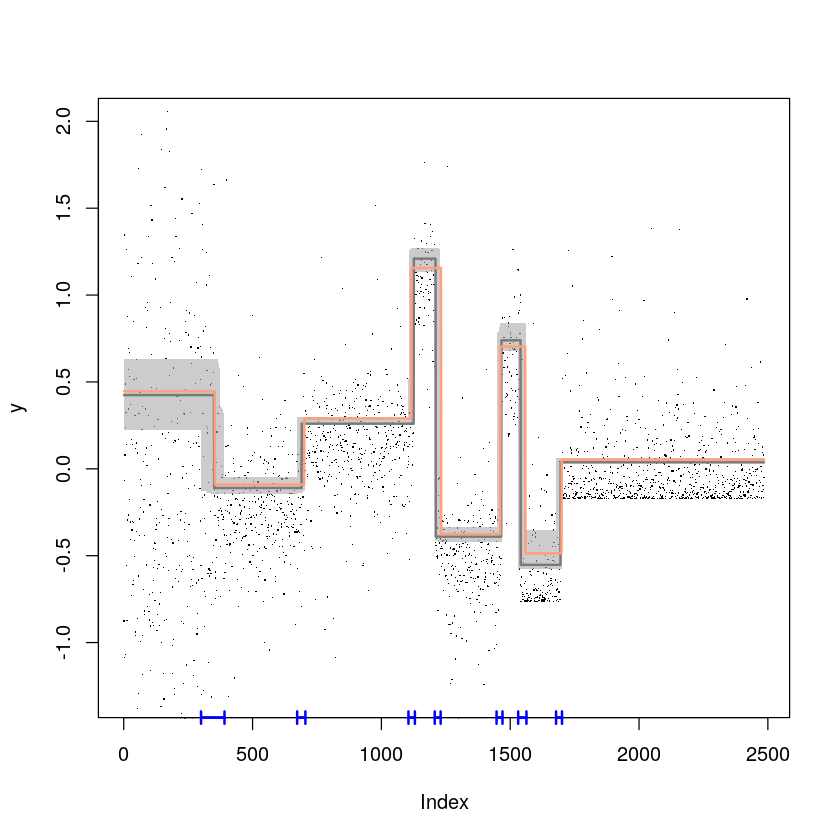

In [32]:
plot(y, pch = ".", ylim = c(-1.3, 2))

# Plot the confidence band 
polygon(c(1:length(mu), rev(1:length(mu))), c(sol$lowerCB, rev(sol$upperCB)), 
        col = rgb(169,169,169, 150, maxColorValue = 255), border =NA)

# Plot the true quantile
Tqup = mu+c(rep(qnorm(0.75, sd = sqrt(1)), 350), rep(qt(0.75, df=3)/sqrt(3)*sqrt(0.1), 1540-350), 
            (rep((qchisq(0.75, 1)-qchisq(0.5,1))/sqrt(2)*sqrt(0.05), length(mu)-1540)))
lines(Tqup, lwd = 2, col="gray48")

# Plot the estimator
lines(fitted(sol), lwd = 2, col = "lightsalmon")

# Plot the confidence intervals
for(i in 1:nrow(sol$confInt)){
  axis(1, at = c(sol$confInt[i,1], sol$confInt[i,2]), labels = c("", ""), lwd = 2, tck=0.01, col="blue")
  axis(1, at = c(sol$confInt[i,1], sol$confInt[i,2]), labels = c("", ""), lwd = 2, tck=-0.01, col="blue")
}

In general, the estimation of quantiles close to 0 or 1, is more challenging. This gets reflected in wider confidence bands and intervals.

### The multiscale box plot (mbp) 

In cases where the distribution of the data is not known, it might be useful to plot several quantiles in order to get structural information of the data. `mqs` has a function that calculate the median, the 0.75- and 0.25-quantiles.

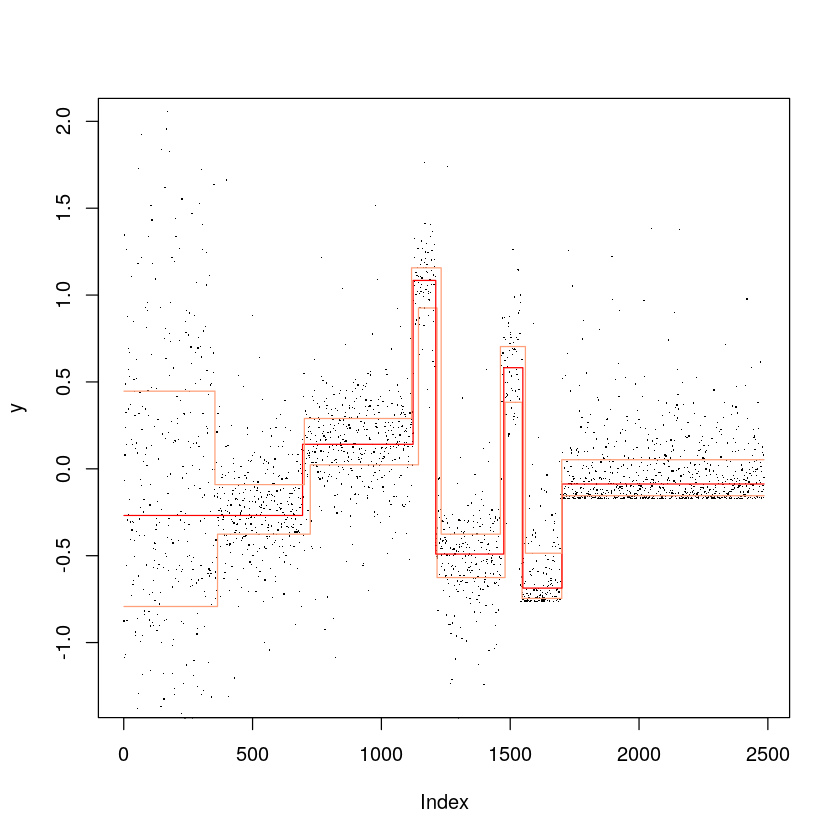

In [34]:
mbp <- mqs.boxplot(y, alpha = 0.1)

plot(y, pch = ".", ylim = c(-1.3, 2))
lines(mbp)

Note that in this case the mbp is able to find the aditional change in variance, while being robust in the median.